In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore',category=[UserWarning, FutureWarning])

### utils

In [2]:
def fill_na_with_rolling_window(data=None, col=None, series=None, n_step=None):
    if col:
        if isinstance(data,pd.DataFrame):
            data['n_roll'] = data[col].rolling(n_step).mean()
            data.loc[data[col].isna(), col] = data.loc[data[col].isna(),'n_roll']
            # display(data.loc[data[col].isna()])
            display(data['n_roll'].isna().sum())
        # elif isinstance(series,pd.Series):
        #     data['n_roll'] = data[col].rolling(n_step)
        #     data.loc[data[col].isna(),col] = data.loc[data[col].isna(),'n_roll']
        else: raise Exception("error")
    return data.drop('n_roll',axis=1)



## Weather Forecasting

In [3]:
weather_data = pd.read_csv('data/spark_renewable_ds_forecast_challenge.csv', parse_dates=False)
weather_data.rename(columns={'TimeStamp (UTC)':'ts',
                             'WindDirection Avg':'wind_direction',
                             'WindSpeed Avg':'wind_speed_avg',
                             'WindSpeed StdDev':'wind_speed_std',
                             'T AMB Avg':'temp',
                             'In AirDensity Avg':'density'},inplace=True)

weather_data['ts'] = pd.to_datetime(weather_data['ts'],utc=True)
print(weather_data.shape)
weather_data.head()

(8760, 6)


,ts,wind_direction,wind_speed_avg,wind_speed_std,temp,density
0,2021-01-01 06:00:00+00:00,NaN,5.110103,NaN,-0.896897,NaN
1,2021-01-01 07:00:00+00:00,NaN,5.221429,NaN,-0.847589,NaN
2,2021-01-01 08:00:00+00:00,NaN,5.411667,NaN,-1.000000,NaN
3,2021-01-01 09:00:00+00:00,NaN,4.855000,NaN,-1.000000,NaN
4,2021-01-01 10:00:00+00:00,NaN,4.369630,NaN,-0.398102,NaN


In [4]:
weather_data.isna().sum(axis=0)

ts                   0
wind_direction    2192
wind_speed_avg      20
wind_speed_std     135
temp                20
density            291
dtype: int64

In [5]:
# checking for correlation
# sns.heatmap(weather_data.corr())

In [6]:
# checking time intervals in data
# (weather_data.ts - weather_data.ts.shift(1)).dt.total_seconds().unique()

In [7]:
# fill missing values in wind speed avg with spline interpolation (linear interpolation also does not show much difference from spline)
# plt.figure(figsize=(14,4))
# plt.plot(weather_data.wind_speed_avg.interpolate(option='linear').iloc[range(0,weather_data.shape[0],5)])
weather_data.interpolate(option='spline',inplace=True)
print("nan in wind speed",weather_data['wind_speed_avg'].isna().sum())

nan in wind speed 0


In [8]:
weather_data.isna().sum(axis=0)

ts                 0
wind_direction    19
wind_speed_avg     0
wind_speed_std    19
temp               0
density           19
dtype: int64

In [21]:
# still seeing nans, because interpolation did not fill nans at the start
# there is only 19 rows with nans now, which we drop because we have large enough data compared to 19 rows
# we can store persistence predictions here, so we do not miss out on one row when we take shift of column for it
persistence_predictions = weather_data.wind_speed_avg.shift(1)
weather_data.dropna(axis=0,inplace=True)

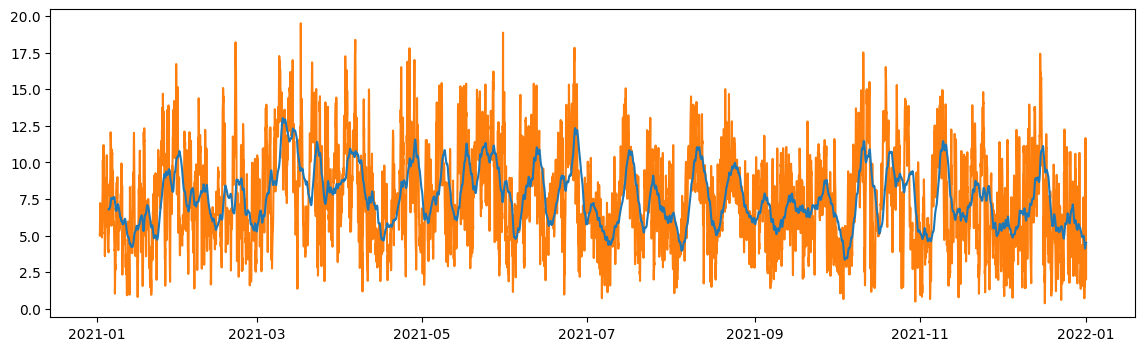

In [10]:
# plt.figure(figsize=(14,4))
# plt.plot(weather_data.set_index('ts').wind_speed_avg.rolling(80).mean(),zorder=13)
# plt.plot(weather_data.set_index('ts').wind_speed_avg)
# # plt.plot(weather_data.loc[~weather_data.wind_speed_avg.isna()].set_index('ts').wind_speed_avg,
# #             # weather_data.loc[~weather_data.wind_speed_avg.isna()]['ts'],
# #             c='blue',alpha=0.3,zorder=49)

# # plt.scatter( temp.loc[weather_data['wind_speed_avg'].isna()]['ts'],
# #     temp.loc[weather_data['wind_speed_avg'].isna()].set_index('ts').wind_speed_avg, 
# #     c='magenta',alpha=1,zorder=1, s=100)
# plt.show()

In [11]:
# # check if nans occuring are together, also see if any observable patterns for wind speed and other
# fig,ax = plt.subplots(weather_data.shape[1]-1,1,figsize=(10,5),sharex=True)
# scaler = MinMaxScaler()
# for i,col in enumerate(weather_data.columns[1:]):
#     ax[i].plot(scaler.fit_transform(weather_data[col].values.reshape(-1,1)))
#     ax[i].set_title(col,size=10)

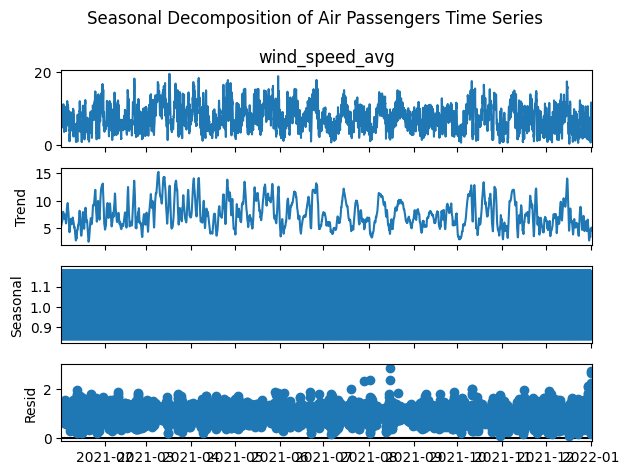

In [12]:
# # check trend, seasonality
# result = seasonal_decompose(weather_data.set_index('ts')['wind_speed_avg'].fillna(weather_data['wind_speed_avg'].mean()), 
#                             model='multiplicative', extrapolate_trend='freq')
# result.plot()
# plt.suptitle('Seasonal Decomposition of Air Passengers Time Series')
# plt.tight_layout()
# plt.show()



[]

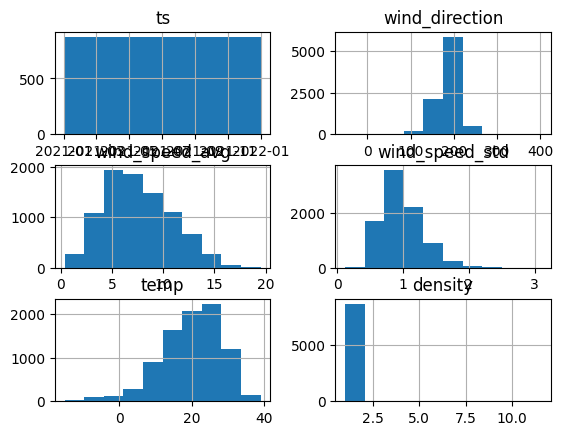

In [13]:
weather_data.hist()
plt.plot()

In [14]:
def add_lag_features(df,col_name,timestep):
    timestep_features = []
    for i in range(1,timestep+1):
        df[f'{i}_lag_{col_name}'] = df[col_name].shift(i)
        timestep_features.append(f'{i}_lag_{col_name}')
    return df, timestep_features

n=48
weather_data, lag_speed_features = add_lag_features(weather_data, 'wind_speed_avg', n)
n=1
weather_data, lag_temp_features = add_lag_features(weather_data, 'temp', n)
weather_data, lag_density_features = add_lag_features(weather_data, 'density', n)
weather_data, lag_direction_features = add_lag_features(weather_data, 'wind_direction', n)

In [17]:
target_col = 'wind_speed_avg'
feature_list = []
feature_list.extend(lag_speed_features)
feature_list.extend(lag_temp_features)
feature_list.extend(lag_density_features)
feature_list.extend(lag_direction_features)

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.8)
pca.fit(weather_data[feature_list])

PCA(n_components=0.8)

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
model = RandomForestRegressor(n_estimators=50, max_depth=9,#int(0.7*(len(feature_list))), 
                              random_state=42, min_weight_fraction_leaf=0.001, 
                              min_samples_leaf=5, min_samples_split=40
                            )

x_train, x_test, y_train, y_test = train_test_split(weather_data[feature_list], weather_data[target_col], test_size=0.1, shuffle=False)
# PCA not improving things
# x_train = pca.transform(x_train)
# x_test = pca.transform(x_test)

# train_set, test_set = [x_train,y_train], [x_train,y_train]
train_set, test_set = [x_train,y_train], [x_test,y_test]

# test_set[1] = target_col_scaler.inverse_transform(test_set[1].values.reshape(-1,1))

model.fit(train_set[0], train_set[1])
predictions = model.predict(test_set[0])

# predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

print("MAE",mean_absolute_error(test_set[1], predictions))
print("RMSE",root_mean_squared_error(test_set[1], predictions))

MAE 0.7822587198458354
RMSE 1.0352979836527452


In [27]:
# persistence model's predictions
print("MAE",mean_absolute_error(test_set[1], persistence_predictions.loc[test_set[1].index]))
print("RMSE",root_mean_squared_error(test_set[1], persistence_predictions.loc[test_set[1].index]))

MAE 0.8469787598091427
RMSE 1.1292722690733275


## Anomaly Detection

In [46]:
time_series = pd.read_csv("data/anomaly_detection.csv")
print(time_series.shape)
time_series.head()

(365, 5)


,CEACC,CCDEF,FAXAE,FBFFD,EDDAB
0,0.000000,0.000000,3.000000,3.000000,8.000000
1,1.232260,-0.217305,3.193780,3.489992,7.792553
2,2.540129,0.606709,3.180950,3.464811,7.817440
3,5.520271,1.470812,3.330528,2.968375,7.409152
4,5.914298,2.745060,3.061706,3.440980,7.153049
